In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from upload_overleaf.upload import upload
import tensorflow as tf

In [2]:
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [ ]:
lf_intraday = (
    pl.scan_parquet("prices.parquet")
    .with_columns([
        pl.col("ticker"),
        pl.col("datetime").alias("date"),
        pl.col("StockOpen").log().alias("log_open"),
        pl.col("StockHigh").log().alias("log_high"),
        pl.col("StockLow").log().alias("log_low"),
        pl.col("StockClose").log().alias("log_close"),
        pl.col("StockVol").alias("volume")
    ])
    .sort(["ticker", "date"])
)

# Calculate the log return within each ticker partition
lf_intraday = (
    lf_intraday
    .select([
        "ticker",
        "date",
        "log_open",
        "log_close",
        "log_high",
        "log_low",
        "volume",
        (pl.col("log_close") - pl.col("log_close").shift(1)).over(pl.col("ticker")).alias("return")
    ])
)

In [3]:
lf_daily = (
    pl.scan_parquet("prices_daily.parquet")
    .with_columns([
        pl.col("ticker"),
        pl.col("datetime").alias("date"),
        pl.col("StockOpen").log().alias("log_open"),
        pl.col("StockHigh").log().alias("log_high"),
        pl.col("StockLow").log().alias("log_low"),
        pl.col("StockClose").log().alias("log_close"),
        pl.col("daily_volume").alias("volume")
    ])
    .sort(["ticker", "date"])
)

# Calculate the log return within each ticker partition
lf_daily = (
    lf_daily
    .select([
        "ticker",
        "date",
        "log_open",
        "log_close",
        "log_high",
        "log_low",
        "volume",
        (pl.col("log_close") - pl.col("log_close").shift(1)).over(pl.col("ticker")).alias("return")
    ])
)

In [ ]:
schema = lf_intraday.schema

In [4]:
unique_tickers = (
    lf_daily.select("ticker")
    .unique()
    .collect()
    .to_pandas()["ticker"]
    .tolist()
)

# Display the list of unique tickers
print(unique_tickers)

['DXCM', 'BIO', 'GRMN', 'MET', 'DUK', 'MMC', 'EA', 'HUBb', 'EVRG', 'ELV', 'WHR', 'EXR', 'SLB', 'MKTX', 'JBHT', 'TFX', 'PFE', 'TGT', 'TRV', 'NTAP', 'EBAY', 'ISRG', 'KMB', 'TT', 'EQR', 'NWS', 'PWR', 'AIZ', 'LVS', 'WELL', 'BR', 'MS', 'LKQ', 'YUM', 'FCX', 'ALB', 'LH', 'CAT', 'AON', 'IFF', 'DVA', 'FMC', 'META', 'CF', 'HIG', 'AME', 'FTV', 'MA', 'NSC', 'MMM', 'ABT', 'MCD', 'LLY', 'CDW', 'BRO', 'EPAM', 'NKE', 'FOX', 'MRK', 'CCI', 'CSX', 'KMX', 'ORLY', 'AIG', 'INTU', 'RL', 'ROST', 'DGX', 'CHD', 'DG', 'STZ', 'SNA', 'TRGP', 'AMCR', 'QRVO', 'JNJ', 'RMD', 'NWSA', 'EMR', 'NI', 'WY', 'J', 'EQIX', 'CZR', 'VFC', 'COR', 'BEN', 'HUM', 'CTLT', 'IT', 'IDXX', 'LDOS', 'ACGL', 'HPE', 'AES', 'NOW', 'BMY', 'PNC', 'LEN', 'INCY', 'CE', 'STX', 'PEP', 'PH', 'MU', 'AAPL', 'NFLX', 'COF', 'STT', 'HON', 'BKR', 'PGR', 'AVGO', 'LULU', 'CINF', 'PAYX', 'FTNT', 'LNT', 'NEE', 'WBD', 'PSX', 'RTX', 'CNC', 'PM', 'ETSY', 'TPR', 'CRL', 'TTWO', 'WYNN', 'V', 'SHW', 'LYV', 'HLT', 'GE', 'KVUE', 'PPL', 'UAL', 'AKAM', 'CMI', 'CTRA', 'C

In [5]:
df_aapl = lf_daily.filter(pl.col("ticker") == "AAPL").collect().to_pandas()

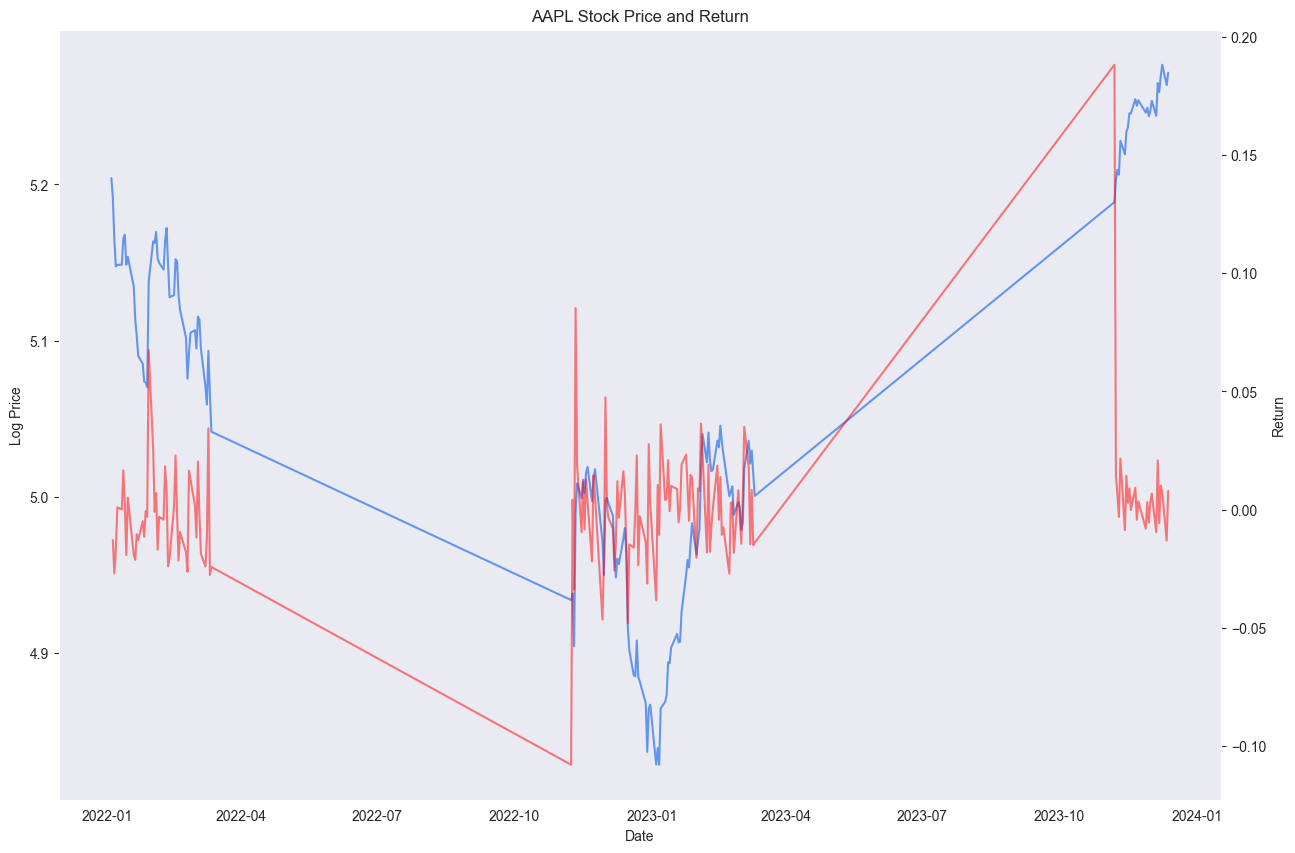

In [6]:
# Plot time series of StockClose
plt.figure(figsize=(15,10))
# Add second y-axis. Left is log price and right is return
ax = sns.lineplot(x="date", y="log_close", data=df_aapl, color="cornflowerblue")
ax2 = ax.twinx()
sns.lineplot(x="date", y="return", data=df_aapl, color="red", ax=ax2, alpha=0.5)
# Disable grid
ax.grid(False)
ax2.grid(False)
ax.set_title("AAPL Stock Price and Return")
ax.set_ylabel("Log Price")
ax2.set_ylabel("Return")
ax.set_xlabel("Date")
plt.show()

In [ ]:
upload(plt, "Master's Thesis", 'figures/aapl_test.png')

/Users/tobiasbrammer/Desktop/MastersThesis/venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/tobiasbrammer/Desktop/MastersThesis/venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/tobiasbrammer/Desktop/MastersThesis/venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = gr

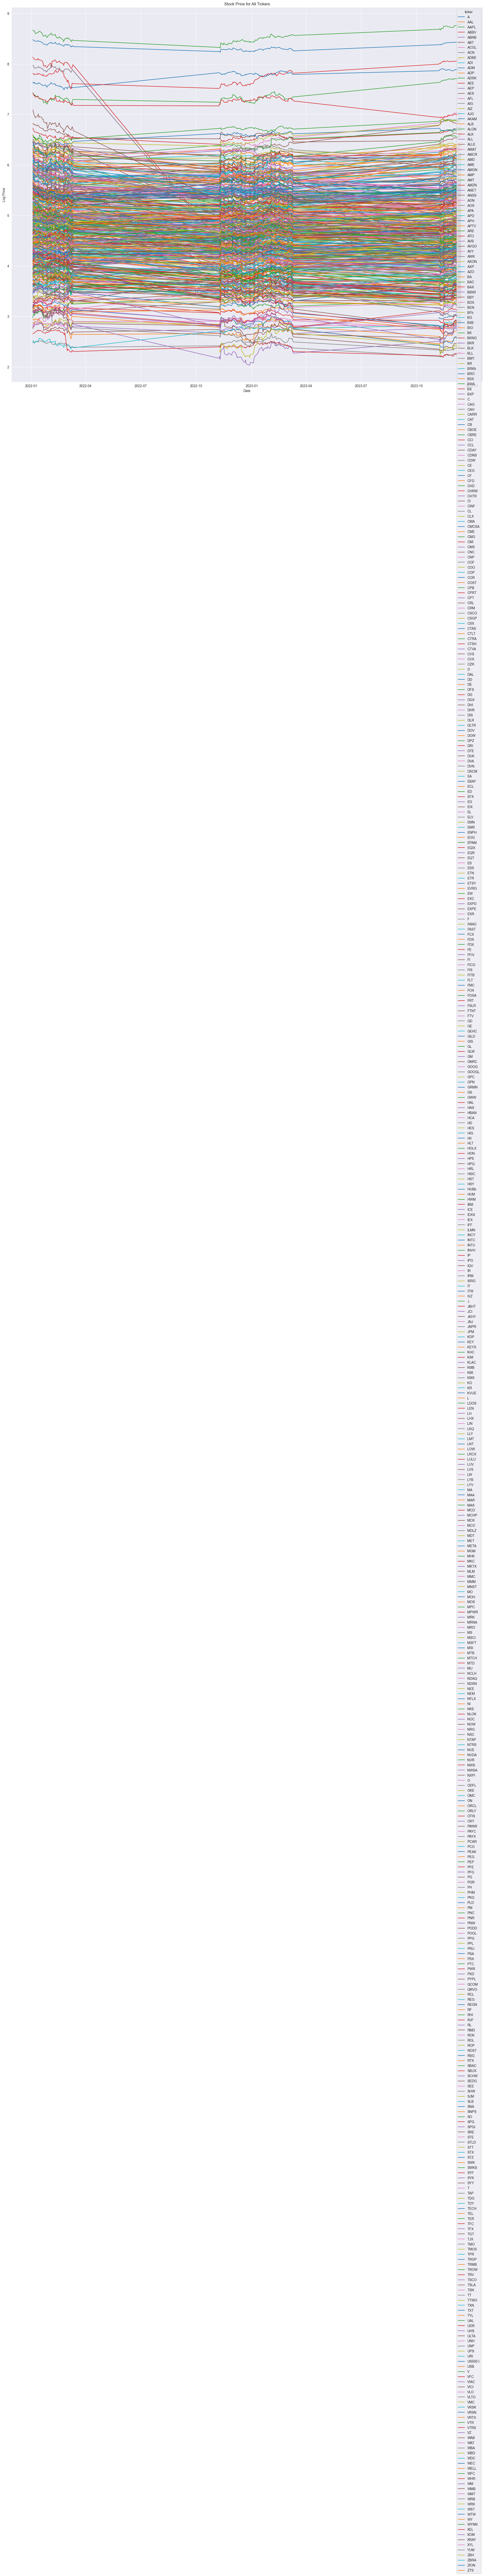

In [7]:
# Plot time series of log_close for all tickers
plt.figure(figsize=(25,20))
ax = sns.lineplot(x="date", y="log_close", hue="ticker", data=lf_daily.collect().to_pandas(), palette="tab10")
ax.set_title("Stock Price for All Tickers")
ax.set_ylabel("Log Price")
ax.set_xlabel("Date")
plt.show()
